In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print('TF_VERSION: {}'.format(tf.__version__))


def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

TF_VERSION: 2.10.0


In [2]:
df = pd.read_csv('../data/processed_reg_data.csv')
df['date'] = pd.to_datetime(df['date']).dt.date

df.head()

,date,btc_price,tweet_volume,likes_gt_0,likes_gt_10,likes_gt_100,likes_gt_1000,retweets_gt_0,retweets_gt_1000,pos_sent,...,hr_12_18,hr_18_24,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,btc_cur_price
0,2016-01-01,433.437988,666,31,0,0,0,212,0,157,...,176,186,1,0,0,0,0,0,0,434.334015
1,2016-01-02,430.010986,625,25,2,0,0,216,0,159,...,134,138,0,0,1,0,0,0,0,433.437988
2,2016-01-03,433.091003,451,20,0,0,0,162,0,149,...,100,124,0,0,0,1,0,0,0,430.010986
3,2016-01-04,431.959991,493,22,1,0,0,143,0,151,...,115,132,0,1,0,0,0,0,0,433.091003
4,2016-01-05,429.105011,455,22,0,0,0,115,0,146,...,118,112,0,0,0,0,0,1,0,431.959991


In [3]:
df.columns

Index(['date', 'btc_price', 'tweet_volume', 'likes_gt_0', 'likes_gt_10',
       'likes_gt_100', 'likes_gt_1000', 'retweets_gt_0', 'retweets_gt_1000',
       'pos_sent', 'neg_sent', 'neu_sent', 'user', 'hr_0_6', 'hr_6_12',
       'hr_12_18', 'hr_18_24', 'Friday', 'Monday', 'Saturday', 'Sunday',
       'Thursday', 'Tuesday', 'Wednesday', 'btc_cur_price'],
      dtype='object')

We can remove `date` column since it will not be used for prediction purposes. 

In [4]:
dates = df['date']
df = df.drop('date', axis=1)

### Standardize & Split data for Train and Test Purpose

We need to standardize the data because the scale of each of the features vary by a lot amount. If we feed the raw data as it is, then the model training will not be appropriate and it increases the chance of overfitting. That's why, let us first standardize the data using `sklearn.preprocessing.StandardScaler`.

In [5]:
df = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)

Let us now divide the dataset into training and testing split. We will use 90% of the dataset for traininga nd 10% of the dataset for test purposes.

In [6]:
y = df['btc_price']
df = df.drop('btc_price', axis=1)
X = df.copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [7]:
print('Number of training examples: {}'.format(X_train.shape[0]))
print('Number of testing examples: {}'.format(X_test.shape[0]))

Number of training examples: 1064
Number of testing examples: 119


Now, we will use the above split dataset for prediction. We will try multiple models on this training data and we will measure the predicted price. We will compare different models based on the MSE (Mean Squared Error) on test data split.

### Linear Regression

In [8]:
reg = LinearRegression().fit(X_train, y_train)

In [9]:
print('MSE for Train Data: {}'.format(
    mean_squared_error(y_train, reg.predict(X_train))
))
print('MSE for Test Data: {}'.format(
    mean_squared_error(y_test, reg.predict(X_test))
))

MSE for Train Data: 0.007045123365137398
MSE for Test Data: 0.0012023806623176995


Text(0, 0.5, 'BTC Price')

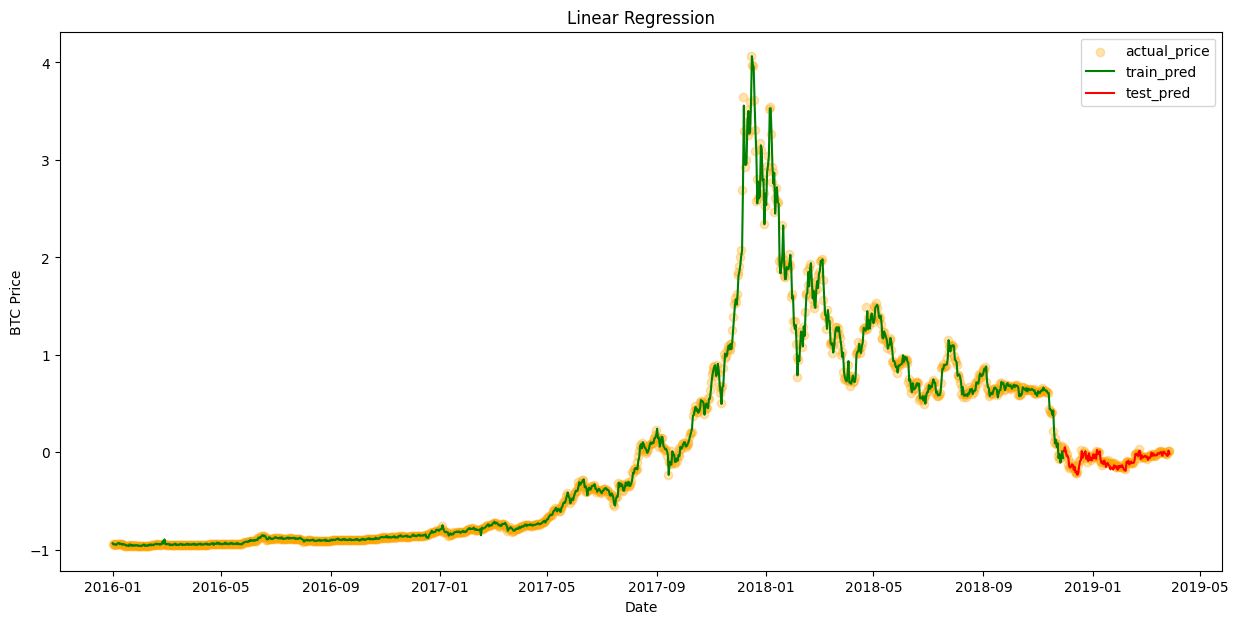

In [48]:
plt.figure(figsize=(15,7))

plt.scatter(dates, y, label='actual_price', color='orange', alpha=0.3)
plt.plot(dates.values[:y_train.shape[0]], reg.predict(X_train), label='train_pred', color='green')
plt.plot(dates.values[-y_test.shape[0]:], reg.predict(X_test), label='test_pred', color='red')
plt.title('Linear Regression')
plt.legend()
plt.xlabel('Date')
plt.ylabel('BTC Price')

We can see that linear regression is able to predict next day price of Bitcoin using today's price and tweet related features. Irrespective of this result, let us also try some other models for price prediction. 

### Ridge Regression

For Ridge regression, we will use `RidgeCV` from `sklearn` which has inbuilt cross validation capability. We will cross validate to find the best value of parameter `alpha` of Ridge regression

In [11]:
alphas = np.logspace(-6, 6, 13)

ridge = RidgeCV(alphas=alphas).fit(X_train, y_train)

In [12]:
print('Best value of alpha={}'.format(ridge.alpha_))

Best value of alpha=10.0


In [13]:
print('MSE for Train Data: {}'.format(
    mean_squared_error(y_train, ridge.predict(X_train))
))
print('MSE for Test Data: {}'.format(
    mean_squared_error(y_test, ridge.predict(X_test))
))

MSE for Train Data: 0.007186072054136067
MSE for Test Data: 0.0009509268219402613


The MSE for Train and Test data are similar in case of Ridge Regression. The predictions seems to be more stable for this type of regression.

Text(0, 0.5, 'BTC Price')

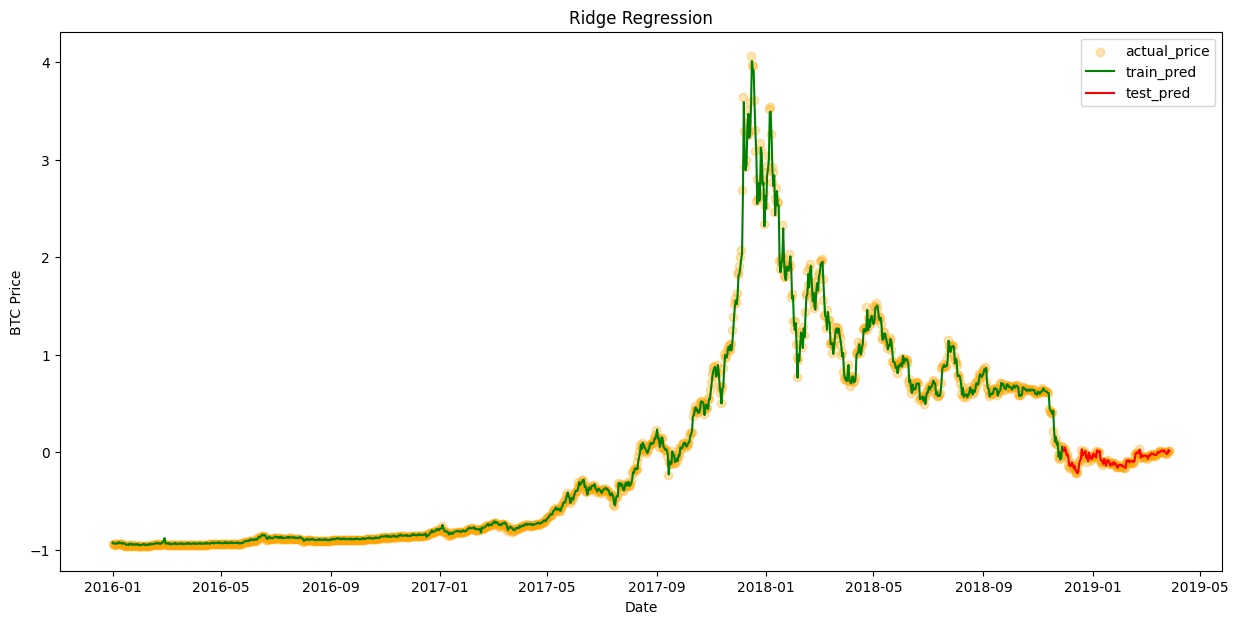

In [49]:
plt.figure(figsize=(15,7))

plt.scatter(dates, y, label='actual_price', color='orange', alpha=0.3)
plt.plot(dates.values[:y_train.shape[0]], ridge.predict(X_train), label='train_pred', color='green')
plt.plot(dates.values[-y_test.shape[0]:], ridge.predict(X_test), label='test_pred', color='red')
plt.title('Ridge Regression')
plt.legend()
plt.xlabel('Date')
plt.ylabel('BTC Price')

### Lasso Regression

For Lasso regression, we will use `Lasso` from `sklearn`. We will cross validate to find the best value of parameters `alpha` and `max_iter` of Lasso regression. We will also use `GridSearchCV` for tuning parameters

In [15]:
def cross_validate_regression(X, y, reg_cls, params, n_splits=3):
    models = GridSearchCV(reg_cls(), params, cv=KFold(n_splits=n_splits)) 
    models.fit(X, y) 
    return models 

params = {
    'alpha': np.logspace(-6, 6, 13),
    'max_iter': [500, 1000, 2000, 5000]
}

lasso_models = cross_validate_regression(X_train, y_train, Lasso, params)

In [16]:
rank_1_index = np.where(lasso_models.cv_results_['rank_test_score']==1)[0][0]
best_params = lasso_models.cv_results_['params'][rank_1_index]

print('Best parameter values found: {}'.format(best_params))

Best parameter values found: {'alpha': 0.001, 'max_iter': 500}


In [17]:
# Create model instance with best parameter values
lasso = Lasso(**best_params).fit(X_train, y_train)

In [18]:
print('MSE for Train Data: {}'.format(
    mean_squared_error(y_train, lasso.predict(X_train))
))
print('MSE for Test Data: {}'.format(
    mean_squared_error(y_test, lasso.predict(X_test))
))

MSE for Train Data: 0.007109531455058174
MSE for Test Data: 0.0010529312316208388


Text(0, 0.5, 'BTC Price')

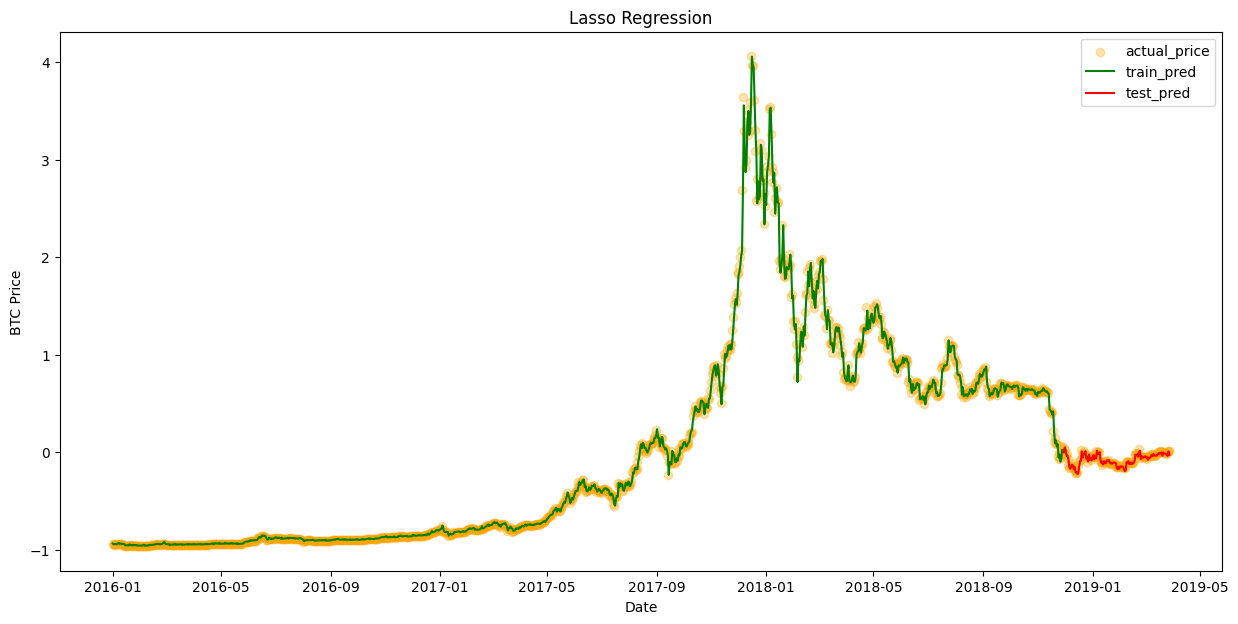

In [50]:
plt.figure(figsize=(15,7))

plt.scatter(dates, y, label='actual_price', color='orange', alpha=0.3)
plt.plot(dates.values[:y_train.shape[0]], lasso.predict(X_train), label='train_pred', color='green')
plt.plot(dates.values[-y_test.shape[0]:], lasso.predict(X_test), label='test_pred', color='red')
plt.title('Lasso Regression')
plt.legend()
plt.xlabel('Date')
plt.ylabel('BTC Price')

From the above plot, we can see that the behavior is similar to linear regression

### Decision Tree Regression

In [20]:
params = {'max_depth': [10, 20, 30, 40, 50, 60, 70]}
dtreg_models = cross_validate_regression(X_train, y_train, DecisionTreeRegressor, params)

In [21]:
print('Best max_depth value={}'.format(
    params['max_depth'][np.where(dtreg_models.cv_results_['rank_test_score']==1)[0][0]]))

Best max_depth value=70


In [22]:
dtreg = DecisionTreeRegressor(max_depth=50).fit(X_train, y_train)

In [23]:
print('MSE for Train Data: {}'.format(
    mean_squared_error(y_train, dtreg.predict(X_train))
))
print('MSE for Test Data: {}'.format(
    mean_squared_error(y_test, dtreg.predict(X_test))
))

MSE for Train Data: 0.0
MSE for Test Data: 0.007480551492270599


Text(0, 0.5, 'BTC Price')

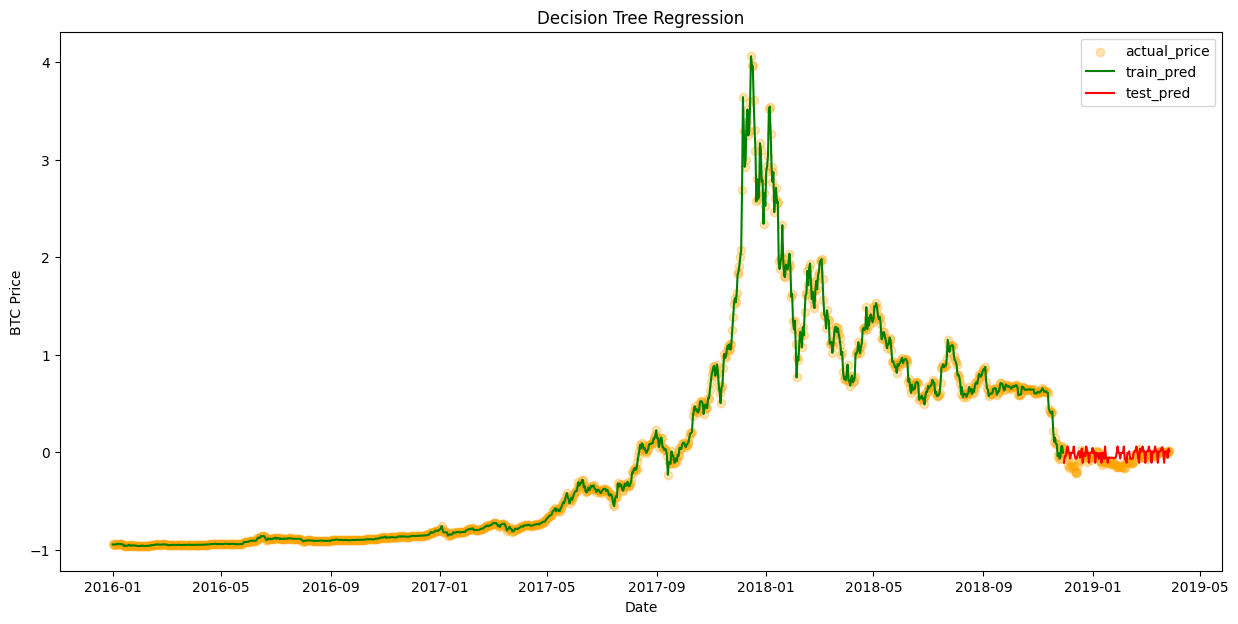

In [51]:
plt.figure(figsize=(15,7))

plt.scatter(dates, y, label='actual_price', color='orange', alpha=0.3)
plt.plot(dates.values[:y_train.shape[0]], dtreg.predict(X_train), label='train_pred', color='green')
plt.plot(dates.values[-y_test.shape[0]:], dtreg.predict(X_test), label='test_pred', color='red')
plt.title('Decision Tree Regression')
plt.legend()
plt.xlabel('Date')
plt.ylabel('BTC Price')

We can see that Decision Tree Regression works good for training data but doesn't perform very well on the test dataset. Decision tree generates rules in form of tree. The tree seems to be overfitting training data (MSE=0) that is why it doesn't perform well on test data.

### Random Forest Regression

In [25]:
params = {
    'n_estimators': [40, 80, 100, 120, 150],
    'max_depth': [10, 20, 30, 40, 50, 60, 70]
}

rfreg_models = cross_validate_regression(X_train, y_train, RandomForestRegressor, params)

In [26]:
rank1_index = np.where(rfreg_models.cv_results_['rank_test_score']==1)[0][0]
best_params = rfreg_models.cv_results_['params'][rank1_index]

print('Best RandomForestRegressor params: {}'.format(best_params))

Best RandomForestRegressor params: {'max_depth': 20, 'n_estimators': 100}


In [27]:
rfreg = RandomForestRegressor(**best_params).fit(X_train, y_train)

In [28]:
print('MSE for Train Data: {}'.format(
    mean_squared_error(y_train, rfreg.predict(X_train))
))
print('MSE for Test Data: {}'.format(
    mean_squared_error(y_test, rfreg.predict(X_test))
))

MSE for Train Data: 0.001270357834467375
MSE for Test Data: 0.00284185942359391


Text(0, 0.5, 'BTC Price')

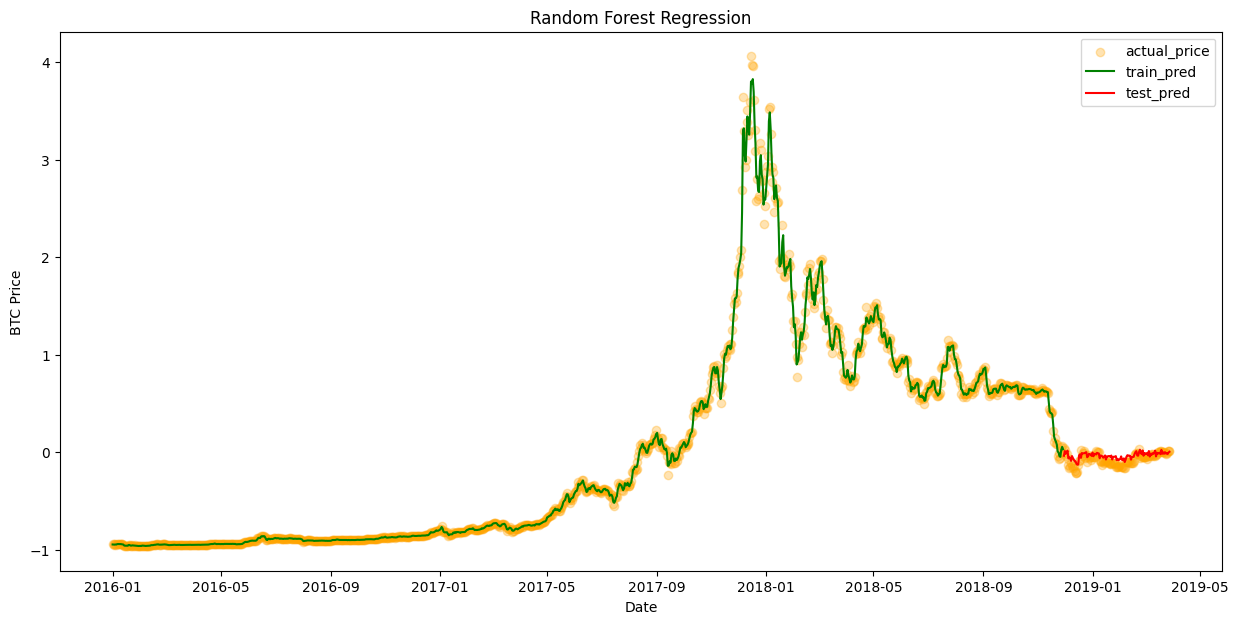

In [52]:
plt.figure(figsize=(15,7))

plt.scatter(dates, y, label='actual_price', color='orange', alpha=0.3)
plt.plot(dates.values[:y_train.shape[0]], rfreg.predict(X_train), label='train_pred', color='green')
plt.plot(dates.values[-y_test.shape[0]:], rfreg.predict(X_test), label='test_pred', color='red')
plt.title('Random Forest Regression')
plt.legend()
plt.xlabel('Date')
plt.ylabel('BTC Price')

Random Forest Regression also performs little better than Decision Tree Regression. But still, it performs very good on training data but it doesn't perform that well for test dataset.

### Artificial Neural Network (ANN)

Let us create small neural network using `tensorflow` API. We will create model with 1 input layer, 1 hidden layer and 1 output layer to predict the price of BTC.

In [42]:
nnreg = tf.keras.Sequential([
    layers.InputLayer(input_shape=X_train.shape[1]),
    layers.Dense(8),
    layers.Dense(1)
])

nnreg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 192       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________


We haven't set any activation function for both of the layers. So, this neural network is similar to applying linear regression 2 times on different dimensional data. Usually `ReLU` activation function is used for hidden layers but we are not using it over here because our final prediction can also be negative whereas `ReLU` only outputs positive values.

In [43]:
nnreg.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_squared_error'
)

nnreg.fit(
    X_train,
    y_train,
    epochs=30,
    validation_split=0.1
)

Epoch 1/30
27/30 [==========================>...] - ETA: 0s - loss: 3.3451

2022-11-24 10:58:14.680136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 7ms/step - loss: 3.0647 - val_loss: 0.2203
Epoch 2/30
30/30 [==============================] - 0s 5ms/step - loss: 0.2585 - val_loss: 0.1763
Epoch 3/30
 1/30 [>.............................] - ETA: 0s - loss: 0.0508

2022-11-24 10:58:14.918518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


30/30 [==============================] - 0s 5ms/step - loss: 0.0954 - val_loss: 0.0651
Epoch 4/30
30/30 [==============================] - 0s 5ms/step - loss: 0.1365 - val_loss: 0.0286
Epoch 5/30
30/30 [==============================] - 0s 5ms/step - loss: 0.1162 - val_loss: 0.0176
Epoch 6/30
30/30 [==============================] - 0s 5ms/step - loss: 0.1812 - val_loss: 0.0537
Epoch 7/30
30/30 [==============================] - 0s 5ms/step - loss: 0.2902 - val_loss: 0.0120
Epoch 8/30
30/30 [==============================] - 0s 5ms/step - loss: 0.0329 - val_loss: 0.0031
Epoch 9/30
30/30 [==============================] - 0s 4ms/step - loss: 0.0211 - val_loss: 0.0044
Epoch 10/30
30/30 [==============================] - 0s 4ms/step - loss: 0.0151 - val_loss: 0.0036
Epoch 11/30
30/30 [==============================] - 0s 4ms/step - loss: 0.0137 - val_loss: 0.0038
Epoch 12/30
30/30 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0045
Epoch 13/30
30/30 [=========

In [44]:
print('MSE for Train Data: {}'.format(
    mean_squared_error(y_train, nnreg.predict(X_train, verbose=0))
))
print('MSE for Test Data: {}'.format(
    mean_squared_error(y_test, nnreg.predict(X_test, verbose=0))
))

MSE for Train Data: 0.008164691003414746
MSE for Test Data: 0.0034713703379684394


2022-11-24 10:58:20.512482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Text(0, 0.5, 'BTC Price')

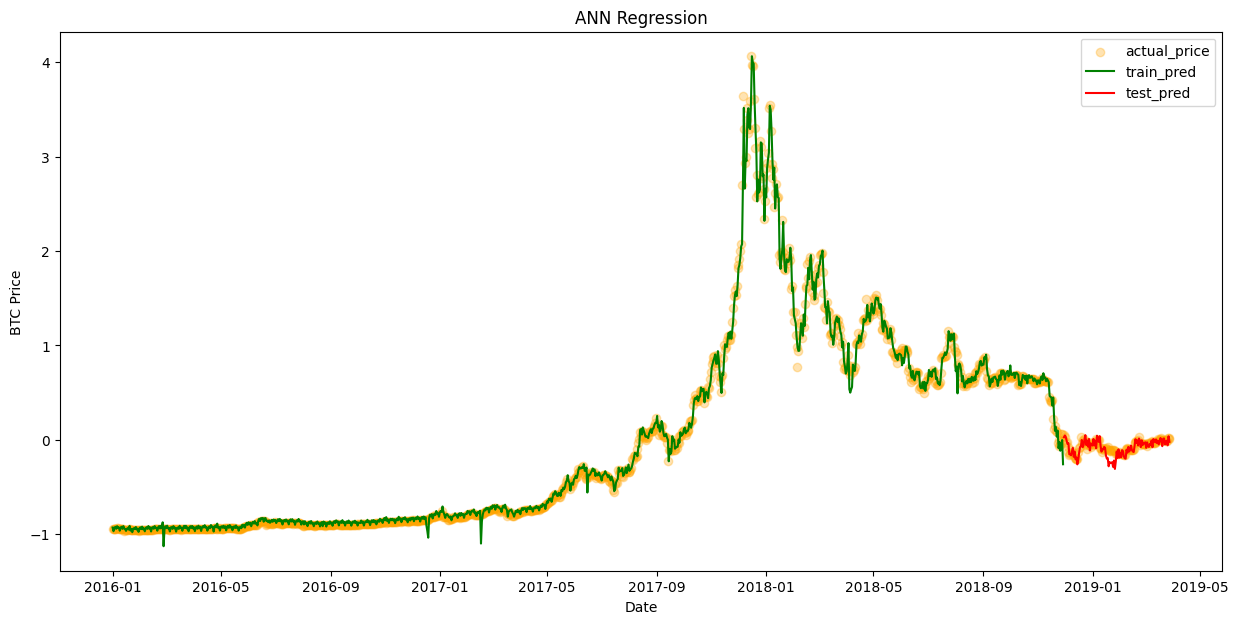

In [53]:
plt.figure(figsize=(15,7))

plt.scatter(dates, y, label='actual_price', color='orange', alpha=0.3)
plt.plot(dates.values[:y_train.shape[0]], nnreg.predict(X_train, verbose=0), label='train_pred', color='green')
plt.plot(dates.values[-y_test.shape[0]:], nnreg.predict(X_test, verbose=0), label='test_pred', color='red')
plt.title('ANN Regression')
plt.legend()
plt.xlabel('Date')
plt.ylabel('BTC Price')

We can see that the neural network also performs similar to linear regression. But we can observe that neural network predictions are unstable for some points in the above plot. But overall it works well. While training neural network, we need to keep in mind that we don't train for very high number of epochs otherwise, it will be overfitted. 

### Model Comparison

Although MSE for all above models looks similar, let us plot the MSE for all models on test data as a bar plot.

In [46]:
models = [reg, ridge, lasso, dtreg, rfreg, nnreg]
names = ['Linear Reg', 'Ridge Reg', 'Lasso Reg', 'Decision Tree Reg', 'Random Forest Reg', 'Artificial Neural Network']
mse = []

for name, model in zip(names, models):
    mse.append(
        mean_squared_error(y_test, model.predict(X_test))
    )

4/4 [==============================] - 0s 3ms/step


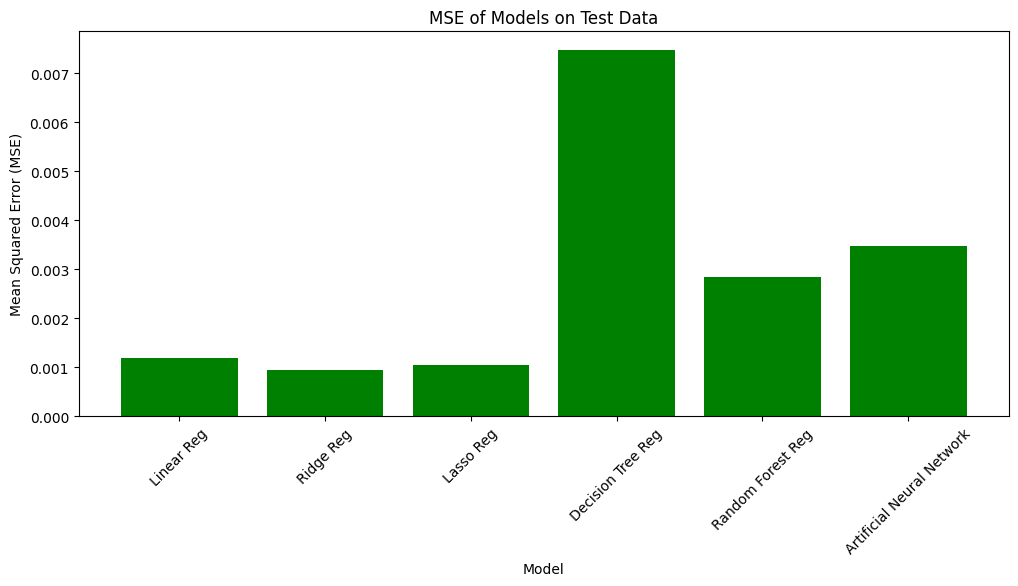

In [47]:
plt.figure(figsize=(12,5))
plt.bar(names, mse, color='green')
plt.title('MSE of Models on Test Data')
plt.xticks(rotation=45)
plt.xlabel('Model')
plt.ylabel('Mean Squared Error (MSE)')
plt.show()

MSE is an error metric. So best performing model must have lowest MSE value.

From above figure, we can see that `DecisionTreeRegressor` has highest MSE and `Ridge` has lowest MSE. It means that the best performing model on test data is `Ridge`. The MSE for `Ridge`, `LinearRegression` and `Lasso` is very similar. `ANN` also doesn't perform well on test dataset as it is the second worst model in terms of MSE.